# Proyecto 1

1.   David Rojas – 202214621
2.   Gabriela García – 202210869
3.   Elkin Cuello – 202215037


# Caso de negocio:  Fondo de Poblaciones de las Naciones Unidas

El Fondo de Poblaciones de las Naciones Unidas (UNFPA) junto con entidades públicas y haciendo uso de diferentes herramientas de participación ciudadana, busca identificar problemas y evaluar soluciones actuales, relacionando la información dada por los ciudadanos con los diferentes Objetivos de Desarrollo Sostenible (ODS). Los ODS fueron adoptados por las Naciones Unidas en 2015 como un llamamiento universal para poner fin a la pobreza, proteger el planeta y garantizar que para el 2030 todas las personas disfruten de paz y prosperidad.

En este contexto, uno de los procesos que requiere mayor esfuerzo es el análisis de la información textual recopilada, ya que consume muchos recursos, que incluyen la participación de un experto. Es así como el UNFPA quiere desarrollar un proyecto con ustedes, donde el objetivo principal es relacionar de forma automática opiniones de los ciudadanos con los ODS 3, 4 y 5. A nivel de la solución a plantear deben aplicar la metodología de desarrollo de aplicaciones analíticas para crear un modelo analítico que sea utilizado y reentrenado por medio de una aplicación web o móvil a partir de un conjunto de opiniones que contienen texto en lenguaje natural.


# 1. Entendimiento de los datos

Importación de librerías

In [5]:
import pandas as pd
import numpy as np

from joblib import dump, load

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, accuracy_score

import scipy.stats as stats

!pip install ydata-profiling
from ydata_profiling import ProfileReport

Carga de datos

In [16]:
opinions_df = pd.read_excel('/content/ODScat_345.xlsx')
opinions_df

,Textos_espanol,sdg
0,"Por ejemplo, el nÃºmero de consultas externas ...",3
1,"En 2007, el gobierno central financió directam...",3
2,"Claramente, hay muchos otros factores en juego...",3
3,"Por ejemplo, el estado australiano de Victoria...",3
4,"El consumo anual de alcohol se estima en 15,7 ...",3
...,...,...
4044,"Para ello, identificará las cuestiones de géne...",5
4045,La participación de las mujeres en roles de li...,5
4046,"Según el WEF, según las tendencias de 2016, po...",5
4047,"Sirve como recurso y foro para las agencias, c...",5


## 1.1 Perfilamiento

Información filas y columnas

In [ ]:
opinions_df.shape

(4049, 2)

Estadísticas básicas de las columnas numéricas

In [ ]:
opinions_df.describe()

,sdg
count,4049.000000
mean,4.051124
std,0.814338
min,3.000000
25%,3.000000
50%,4.000000
75%,5.000000
max,5.000000


Tipos de datos de las columnas

In [ ]:
opinions_df.dtypes

,0
Textos_espanol,object
sdg,int64


### Visualización y perfilamiento general con Ydata

In [ ]:
profile_report = ProfileReport(opinions_df, title="Pandas Profiling Report")
profile_report

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Conclusiones
Se ha obtenido por parte de la UNFPA, una colección extensa de datos donde se clasifica una lista de comentarios respecto al objetivo de desarrollo sostenible ODS (3, 4 o 5) al que corresponden. Los datos han sido recolectados en un archivo de excel en el cual cada registro corresponde a un comentario de un ODS.

En total, se obtuvieron 4049 filas, cada una detallada por 2 columnas, donde en la primera (Textos_espanol) se muestra el comentario, y en la segunda (sdg) el ODS al que corresponden (3, 4 o 5). De estas columnas, la primera es de tipo texto y la segunda es de tipo categórica, respectivamente.

Ninguna columna identifica de manera única cada opinión ciudadana, sin embargo, la coincidencia en la columna tipo texto de dos opiniones que se registren como distintas es improbable.

Además se puede observar que la distribución de los valores de la columna sdg es la siguiente:

* ODS 5: 1451 registros (36%)
* ODS 4: 1354 registros (33%)
* ODS 3: 1244 registros (30%)






## 1.2 Análisis de calidad

### 1.2.1 Unicidad

Duplicados totales:

In [ ]:
opinions_df.duplicated(keep = False).sum()

0

Duplicados Parciales:

In [ ]:
num= opinions_df.duplicated(subset = "Textos_espanol").sum()
print(num)

0


### 1.2.2 Completitud

In [ ]:
opinions_df.isnull().sum()

,0
Textos_espanol,0
sdg,0


### 1.2.3 Consistencia

In [ ]:
opinions_df_copy=opinions_df.copy()
# Lista de palabras relacionadas con ODS 3: Salud y Bienestar
ods_salud_bienestar = [
    "salud",
    "bienestar",
    "Prevención",
    "enfermedades",
    "atención medica",
    "vacunacion",
    "nutrición",
    "salud mental",
    "higiene",
    "saneamiento",
    "ejercicio",
    "estilos de vida saludables",
    "mortalidad infantil",
    "esperanza de vida",
    "servicios de salud","farmaco", "consultas", "hospitales", "centros de salud"
]

# Lista de palabras relacionadas con ODS 4: Educación de Calidad
ods_educacion_calidad = [
    "educacion",
    "inclusion","escuelas", "universidades"
    "acceso a la educacion",
    "alfabetizacion",
    "calidad educativa",
    "igualdad de oportunidades",
    "docentes","maestros"
    "aprendizaje",
    "curriculo",
    "innovacion educativa",
    "infraestructura educativa",
    "educacion digital",
    "educacion temprana",
    "formacion tecnica",
    "becas", "estudiantes"
]

# Lista de palabras relacionadas con ODS 5: Igualdad de Género
ods_igualdad_genero = [
    "igualdad",
    "empoderamiento",
    "violencia de genero",
    "mujer","niña"
    "discriminacion",
    "equidad salarial",
    "participacion politica",
    "educacion en igualdad",
    "salud reproductiva",
    "liderazgo femenino",
    "autonomia economica",
    "independencia economica",
    "acoso",
    "estereotipos de genero",
    "justicia de genero"
]

def verificar_ods(opinion, ods_palabras):
    opinion = opinion.lower()
    for palabra in ods_palabras:
        if palabra in opinion:
            return True
    return False

def verificar_consistencia(row):
    if row['sdg'] == 3:
        return verificar_ods(row['Textos_espanol'], ods_salud_bienestar)
    elif row['sdg'] == 4:
        return verificar_ods(row['Textos_espanol'], ods_educacion_calidad)
    elif row['sdg'] == 5:
        return verificar_ods(row['Textos_espanol'], ods_igualdad_genero)
    else:
        return False


opinions_df_copy['consistente'] =opinions_df_copy.apply(verificar_consistencia, axis=1)
consistencia_por_ods = opinions_df_copy.groupby('sdg')['consistente'].mean() * 100

print(consistencia_por_ods)



sdg
3    69.935691
4    61.890694
5    90.420400
Name: consistente, dtype: float64


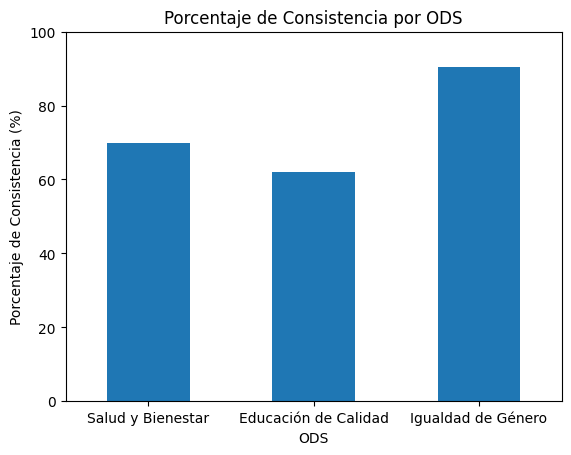

In [ ]:

consistencia_por_ods.plot(kind='bar',rot=0)
plt.title('Porcentaje de Consistencia por ODS')
plt.xlabel('ODS')
plt.ylabel('Porcentaje de Consistencia (%)')
plt.ylim(0, 100)
plt.xticks([0, 1, 2], ['Salud y Bienestar', 'Educación de Calidad', 'Igualdad de Género'])
plt.show()


sdg
3    30.948553
4    20.827179
5    27.015851
Name: consistente, dtype: float64


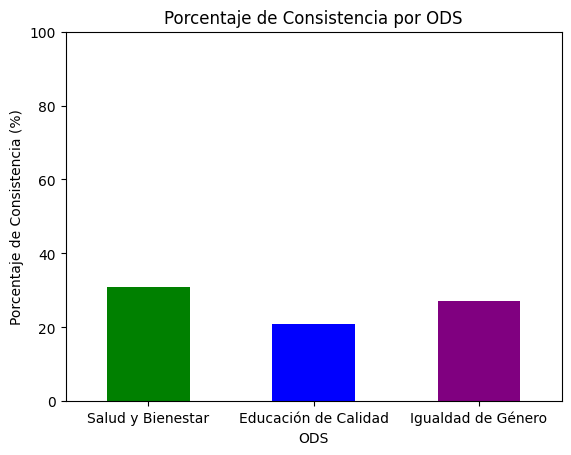

In [ ]:
opinions_df_copy2 = opinions_df.copy()

def verificar_ods_2(opinion, ods_palabras):
    # Convertir la opinión a minúsculas y verificar si contiene al menos dos palabras clave
    opinion = opinion.lower()
    count = 0
    for palabra in ods_palabras:
        if palabra in opinion:
            count += 1
        if count >= 2:
            return True
    return False

def verificar_consistencia2(row):
  if row['sdg'] == 3:
      return verificar_ods_2(row['Textos_espanol'], ods_salud_bienestar)
  elif row['sdg'] == 4:
      return verificar_ods_2(row['Textos_espanol'], ods_educacion_calidad)
  elif row['sdg'] == 5:
      return verificar_ods_2(row['Textos_espanol'], ods_igualdad_genero)
  else:
    return False

opinions_df_copy2['consistente'] = opinions_df_copy2.apply(verificar_consistencia2, axis=1)

consistencia_por_ods2 = opinions_df_copy2.groupby('sdg')['consistente'].mean() * 100

# Mostrar los resultados
print(consistencia_por_ods2)
# Graficar los porcentajes de consistencia
consistencia_por_ods2.plot(kind='bar', color=['green', 'blue', 'purple'], rot=0)
plt.title('Porcentaje de Consistencia por ODS')
plt.xlabel('ODS')
plt.ylabel('Porcentaje de Consistencia (%)')
plt.ylim(0, 100)  # Establecer los límites del eje y de 0 a 100
plt.xticks([0, 1, 2], ['Salud y Bienestar', 'Educación de Calidad', 'Igualdad de Género'])
plt.show()


### 1.2.4 Validez

In [ ]:

opinions_df_copy["Lenght del mensaje"]= opinions_df_copy["Textos_espanol"].str.len()

In [ ]:
opinions_df_copy["Lenght del mensaje"].describe()

,Lenght del mensaje
count,4049.000000
mean,699.632502
std,228.988965
min,294.000000
25%,531.000000
50%,657.000000
75%,827.000000
max,1513.000000


Podemos ver que cada una de las opiones tiene entre 294 y 1513 palabras, lo que me indica que dontiene una opinion completa y no solo palabras.

Po otro lado, existen caracteres especiales, como la ñ y las tildes que por error de codificacion de texto. Esto se solucionea mediante lemmatizando cada opición.

In [ ]:

print(opinions_df["Textos_espanol"][1720])
print("-----")
print(opinions_df["Textos_espanol"][3326])
print("-----")
print(opinions_df["Textos_espanol"][3230])



El acuerdo aboga por polÃticas integrales y un enfoque centrado en la atenciÃ³n a los segmentos pobres, vulnerables y excluidos de la sociedad, de acuerdo con sus necesidades, caracterÃsticas y contextos particulares. Ciencia y Cultura (OEI), los ministros de Educación aprobaron un proyecto integral para la primera infancia que es el eje del proyecto "Metas 2021: La Educación que Queremos para la Generación del Bicentenario" (CEPAL/OEI/SEGIB, 2010). Tal es el caso de países con asistencia más generalizada, como Uruguay (4 años) y México (3).
-----
En los Ãºltimos aÃ±os se han realizado esfuerzos para construir y rehabilitar escuelas en zonas necesitadas. El programa "100 escuelas, 100 hospitales", anunciado por el Presidente de KazajstÃ¡n en 2007, ha construido 106 nuevas escuelas que ofrecen mÃ¡s de 86.000 plazas adicionales para estudiantes en todo el paÃs. El objetivo del programa, financiado en gran medida a través de transferencias de desarrollo específicas (TDT) del presupuesto r

# 2. Preparación de los datos

In [10]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

import re
import unicodedata
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re, string, unicodedata
import inflect
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import LancasterStemmer, WordNetLemmatizer
from sklearn.base import BaseEstimator, TransformerMixin

!pip install num2words
from num2words import num2words

from sklearn.feature_extraction.text import TfidfVectorizer

!pip install spacy
import spacy
!python -m spacy download es_core_news_sm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.3/143.3 kB 7.5 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=8b25fc80e626f3b68a62b45af5f499b5afb53350e23bec976c83645897ca988a
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 50.6 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [11]:
class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords = set(stopwords.words('spanish'))

    def clean_text(self, text):
        # Reemplazar caracteres especiales
        text = text.replace('Ã±', 'ñ')
        text = text.replace('Ã¡', 'á')
        text = text.replace('Ã©', 'é')
        text = text.replace('Ã­', 'í')
        text = text.replace('Ã³', 'ó')
        text = text.replace('Ãº', 'ú')
        text = text.replace('Ã', 'a')
        text = text.replace('Ã©', 'e')
        text = text.replace('Ã­', 'i')
        text = text.replace('Ã³', 'o')
        text = text.replace('Ãº', 'u')

        # Convertir a minúsculas
        text = text.lower()

        # Eliminar números
        text = re.sub(r'\d+', '', text)

        # Eliminar símbolos y puntuación, pero mantener caracteres válidos en español
        text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑ\s]', '', text)

        # Eliminar espacios adicionales
        text = re.sub(r'\s+', ' ', text).strip()

        # Eliminar stopwords
        words = text.split()
        words = [word for word in words if word not in self.stopwords]

        # Reconstruir el texto
        text = ' '.join(words)

        return text

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X.apply(self.clean_text)

In [12]:
class Tokenizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.stopwords = set(stopwords.words('spanish'))

    def tokenize(self, text):
        # Tokenizar el texto
        return nltk.word_tokenize(text)

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Eliminar filas con valores nulos en X
        X = X.dropna()

        # Tokenizar cada texto en la serie
        return X.apply(self.tokenize)

In [13]:
class Normalizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        # Cargar el modelo de spaCy para español
        self.nlp = spacy.load('es_core_news_sm')
        self.stopwords = set(stopwords.words('spanish'))

    def lemmatize_tokens(self, tokens):
        doc = self.nlp(' '.join(tokens))
        lemmatized_tokens = []

        for token in doc:
            # Verificar si el lema tiene más de una palabra
            if len(token.lemma_.split()) > 1:
                # Dividir el lema en palabras individuales
                for word in token.lemma_.split():
                    # Añadir la palabra si no es una stopword
                    if word not in self.stopwords:
                        lemmatized_tokens.append(word)
            else:
                lemmatized_tokens.append(token.lemma_)

        return lemmatized_tokens

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        # Aplica la lematización a cada lista de tokens en la serie
        return X.apply(lambda tokens: self.lemmatize_tokens(tokens))

In [14]:
from sklearn.pipeline import Pipeline

def identity_tokenizer(tokens):
    return tokens

def identity_preprocessor(text):
    return text

pipeline = Pipeline([
    ('cleaner', DataCleaner()),        # Limpieza de datos
    ('tokenizer', Tokenizer()),        # Tokenización y eliminación de nulos
    ('normalizer', Normalizer()),      # Lematización de tokens
    ('tfidf', TfidfVectorizer(tokenizer= identity_tokenizer, preprocessor= identity_preprocessor)),  # Vectorización TF-IDF
])
pipeline

Pipeline(steps=[('cleaner', DataCleaner()), ('tokenizer', Tokenizer()),
                ('normalizer', Normalizer()),
                ('tfidf',
                 TfidfVectorizer(preprocessor=<function identity_preprocessor at 0x7b23d073d630>,
                                 tokenizer=<function identity_tokenizer at 0x7b23d073d510>))])

In [ ]:
opinions_df['Textos_espanol'].iloc[0]

'Por ejemplo, el nÃºmero de consultas externas de especialistas es de 319 por cada mil derechohabientes en el SP, en comparaciÃ³n con 338 y 620 por cada mil derechohabientes en el IMSS y el ISSSTE, respectivamente. Si bien algunas de estas diferencias pueden reflejar una necesidad desigual (como la poblaciÃ³n ligeramente mayor del ISSSTE), otras no pueden justificarse de esta manera. El nÃºmero de recetas que no pudieron ser surtidas en su totalidad por un farmacÃ©utico debido a la falta de existencias es de 33% dentro del SP en comparaciÃ³n con 14% dentro del IMSS segÃºn los datos de la encuesta (aunque las propias cifras de los institutos de la SS sugieren tasas mÃ¡s altas de recetas surtidas). Ambas cifras se encuentran entre las mÃ¡s altas de la OCDE. El gasto de bolsillo no se ha reducido significativamente en la última década, a pesar de los esfuerzos para lograr la cobertura sanitaria universal a través de la reforma del SP.'

In [ ]:
opinions_cleaned = pipeline.named_steps['cleaner'].transform(opinions_df['Textos_espanol'])
opinions_cleaned.iloc[0]

'ejemplo número consultas externas especialistas cada mil derechohabientes sp comparación cada mil derechohabientes imss issste respectivamente si bien diferencias pueden reflejar necesidad desigual población ligeramente mayor issste pueden justificarse manera número recetas pudieron ser surtidas totalidad farmacéutico debido falta existencias dentro sp comparación dentro imss según datos encuesta aunque propias cifras institutos ss sugieren tasas altas recetas surtidas ambas cifras encuentran altas ocde gasto bolsillo reducido significativamente última década pesar esfuerzos lograr cobertura sanitaria universal través reforma sp'

In [ ]:
opinions_cleaned.iloc[0]

'ejemplo número consultas externas especialistas cada mil derechohabientes sp comparación cada mil derechohabientes imss issste respectivamente si bien diferencias pueden reflejar necesidad desigual población ligeramente mayor issste pueden justificarse manera número recetas pudieron ser surtidas totalidad farmacéutico debido falta existencias dentro sp comparación dentro imss según datos encuesta aunque propias cifras institutos ss sugieren tasas altas recetas surtidas ambas cifras encuentran altas ocde gasto bolsillo reducido significativamente última década pesar esfuerzos lograr cobertura sanitaria universal través reforma sp'

In [ ]:
opinions_tokenized = pipeline.named_steps['tokenizer'].transform(opinions_cleaned)
opinions_tokenized.iloc[0]

['ejemplo',
 'número',
 'consultas',
 'externas',
 'especialistas',
 'cada',
 'mil',
 'derechohabientes',
 'sp',
 'comparación',
 'cada',
 'mil',
 'derechohabientes',
 'imss',
 'issste',
 'respectivamente',
 'si',
 'bien',
 'diferencias',
 'pueden',
 'reflejar',
 'necesidad',
 'desigual',
 'población',
 'ligeramente',
 'mayor',
 'issste',
 'pueden',
 'justificarse',
 'manera',
 'número',
 'recetas',
 'pudieron',
 'ser',
 'surtidas',
 'totalidad',
 'farmacéutico',
 'debido',
 'falta',
 'existencias',
 'dentro',
 'sp',
 'comparación',
 'dentro',
 'imss',
 'según',
 'datos',
 'encuesta',
 'aunque',
 'propias',
 'cifras',
 'institutos',
 'ss',
 'sugieren',
 'tasas',
 'altas',
 'recetas',
 'surtidas',
 'ambas',
 'cifras',
 'encuentran',
 'altas',
 'ocde',
 'gasto',
 'bolsillo',
 'reducido',
 'significativamente',
 'última',
 'década',
 'pesar',
 'esfuerzos',
 'lograr',
 'cobertura',
 'sanitaria',
 'universal',
 'través',
 'reforma',
 'sp']

In [ ]:
opinions_tokenized.iloc[0]

['ejemplo',
 'número',
 'consultas',
 'externas',
 'especialistas',
 'cada',
 'mil',
 'derechohabientes',
 'sp',
 'comparación',
 'cada',
 'mil',
 'derechohabientes',
 'imss',
 'issste',
 'respectivamente',
 'si',
 'bien',
 'diferencias',
 'pueden',
 'reflejar',
 'necesidad',
 'desigual',
 'población',
 'ligeramente',
 'mayor',
 'issste',
 'pueden',
 'justificarse',
 'manera',
 'número',
 'recetas',
 'pudieron',
 'ser',
 'surtidas',
 'totalidad',
 'farmacéutico',
 'debido',
 'falta',
 'existencias',
 'dentro',
 'sp',
 'comparación',
 'dentro',
 'imss',
 'según',
 'datos',
 'encuesta',
 'aunque',
 'propias',
 'cifras',
 'institutos',
 'ss',
 'sugieren',
 'tasas',
 'altas',
 'recetas',
 'surtidas',
 'ambas',
 'cifras',
 'encuentran',
 'altas',
 'ocde',
 'gasto',
 'bolsillo',
 'reducido',
 'significativamente',
 'última',
 'década',
 'pesar',
 'esfuerzos',
 'lograr',
 'cobertura',
 'sanitaria',
 'universal',
 'través',
 'reforma',
 'sp']

In [ ]:
opinions_normalized = pipeline.named_steps['normalizer'].transform(opinions_tokenized)
opinions_normalized.iloc[0]

['ejemplo',
 'número',
 'consulta',
 'externo',
 'especialista',
 'cada',
 'mil',
 'derechohabient',
 'sp',
 'comparación',
 'cada',
 'mil',
 'derechohabient',
 'imss',
 'issstar',
 'respectivamente',
 'si',
 'bien',
 'diferencia',
 'poder',
 'reflejar',
 'necesidad',
 'desigual',
 'población',
 'ligeramente',
 'mayor',
 'issste',
 'poder',
 'justificar',
 'manera',
 'número',
 'receta',
 'poder',
 'ser',
 'surtir',
 'totalidad',
 'farmacéutico',
 'debido',
 'faltar',
 'existencia',
 'dentro',
 'sp',
 'comparación',
 'dentro',
 'imss',
 'según',
 'dato',
 'encuesta',
 'aunque',
 'propio',
 'cifra',
 'instituto',
 's',
 'sugerir',
 'tasa',
 'alto',
 'receta',
 'surtida',
 'ambos',
 'cifra',
 'encontrar',
 'alto',
 'ocde',
 'gasto',
 'bolsillo',
 'reducido',
 'significativamente',
 'último',
 'décado',
 'pesar',
 'esfuerzo',
 'lograr',
 'cobertura',
 'sanitario',
 'universal',
 'través',
 'reforma',
 'sp']

In [ ]:
opinions_normalized.iloc[0]

['ejemplo',
 'número',
 'consulta',
 'externo',
 'especialista',
 'cada',
 'mil',
 'derechohabient',
 'sp',
 'comparación',
 'cada',
 'mil',
 'derechohabient',
 'imss',
 'issstar',
 'respectivamente',
 'si',
 'bien',
 'diferencia',
 'poder',
 'reflejar',
 'necesidad',
 'desigual',
 'población',
 'ligeramente',
 'mayor',
 'issste',
 'poder',
 'justificar',
 'manera',
 'número',
 'receta',
 'poder',
 'ser',
 'surtir',
 'totalidad',
 'farmacéutico',
 'debido',
 'faltar',
 'existencia',
 'dentro',
 'sp',
 'comparación',
 'dentro',
 'imss',
 'según',
 'dato',
 'encuesta',
 'aunque',
 'propio',
 'cifra',
 'instituto',
 's',
 'sugerir',
 'tasa',
 'alto',
 'receta',
 'surtida',
 'ambos',
 'cifra',
 'encontrar',
 'alto',
 'ocde',
 'gasto',
 'bolsillo',
 'reducido',
 'significativamente',
 'último',
 'décado',
 'pesar',
 'esfuerzo',
 'lograr',
 'cobertura',
 'sanitario',
 'universal',
 'través',
 'reforma',
 'sp']

In [ ]:
X_transformed = pipeline.named_steps['tfidf'].fit_transform(opinions_normalized)
print(X_transformed[:5])
print(X_transformed.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


  (0, 11469)	0.07176085684753922
  (0, 13438)	0.06451670525106537
  (0, 13624)	0.09050388191536644
  (0, 12091)	0.06684908725290006
  (0, 2397)	0.08876067977844825
  (0, 8245)	0.07078452876508395
  (0, 5041)	0.06994117971685415
  (0, 10247)	0.08364243204051894
  (0, 4405)	0.08493356145041331
  (0, 14223)	0.0671986335386999
  (0, 12408)	0.08899949321185283
  (0, 11420)	0.09950515166803801
  (0, 1639)	0.10566586773273746
  (0, 6059)	0.06985900250998436
  (0, 9573)	0.05047796047121568
  (0, 4747)	0.0692149019918281
  (0, 649)	0.08674441132532003
  (0, 12927)	0.15324253860126397
  (0, 612)	0.10219077464144596
  (0, 13061)	0.06095202692552834
  (0, 12843)	0.07573087822222495
  (0, 12010)	0.11415098302802369
  (0, 7319)	0.09364327726791437
  (0, 2271)	0.20078980749354874
  (0, 10929)	0.07441239856304532
  :	:
  (4, 8644)	0.08090426065775112
  (4, 4743)	0.12418168267133506
  (4, 6594)	0.14299966854315102
  (4, 1365)	0.12497188560131664
  (4, 8190)	0.17736569067437832
  (4, 5172)	0.12171830555

In [ ]:
terms = pipeline.named_steps['tfidf'].get_feature_names_out()
print(terms[10904])

promueve


In [ ]:
print(terms[600:630])

['altamente' 'altas' 'alterado' 'alterar' 'altere' 'alterna' 'alternar'
 'alternarar' 'alternativa' 'alternativamente' 'alternativo' 'altero'
 'alto' 'altocaso' 'altos' 'altruismo' 'altruista' 'altura' 'alturar'
 'alturki' 'altísir' 'alumbrado' 'alumna' 'alumnado' 'alumno'
 'alumnoprofesor' 'alusro' 'alytus' 'alza' 'alzado']


In [ ]:
print(X_transformed[:, 3])

  (1249, 0)	0.13802212241603595


# 3. Modelado

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

## Red Neuronal

Implementado por David Rojas

In [17]:
pipeline_neural_net = Pipeline([
    ('cleaner', DataCleaner()),        # Limpieza de datos
    ('tokenizer', Tokenizer()),        # Tokenización y eliminación de nulos
    ('normalizer', Normalizer()),      # Lematización de tokens
    ('tfidf', TfidfVectorizer(tokenizer= identity_tokenizer, preprocessor= identity_preprocessor)),  # Vectorización TF-IDF
    ('classifier', MLPClassifier(activation= 'logistic',
                                 alpha= 0.008065429868602328,
                                 hidden_layer_sizes= (150,),
                                 learning_rate= 'constant',
                                 max_iter= 220,
                                 solver= 'lbfgs'))  # Red neuronal simple
])

X = opinions_df['Textos_espanol']
y = opinions_df['sdg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline_neural_net.fit(X_train, y_train)

y_pred = pipeline_neural_net.predict(X_test)

results_df = pd.DataFrame({
    'Opinión': X_test,
    'Predicción': y_pred
})
results_df


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,Opinión,Predicción
1159,Los directores de escuela reclutados bajo el n...,4
149,En su segunda fase integró una historia clínic...,3
3909,"Como prioridad, se deben tomar medidas para ga...",3
3523,"Además, la formación de especialistas en medic...",3
3206,Entre las personalidades que asistieron se enc...,5
...,...,...
3350,Los nuevos planes de estudios (que han pasado ...,4
436,Las tasas de mortalidad ajustadas por edad aum...,3
3477,Dos aspectos principales de esta relación son ...,4
3690,"En Jordania, el 52 % de la mano de obra femeni...",5


In [ ]:
# F1 Score
f1 = f1_score(y_test, y_pred, average='weighted')
f1

0.9752927574062237

Selección de los mejores hiperparámetros mediante la búsqueda aleatorizada en cuuadrícula.

In [ ]:
'''
param_dist = {
    'classifier__hidden_layer_sizes': [(50,), (100,), (150,), (100, 100), (200, 200)],  # Diferentes tamaños de capas ocultas
    'classifier__activation': ['tanh', 'relu', 'logistic'],  # Funciones de activación
    'classifier__solver': ['sgd', 'adam', 'lbfgs'],  # Algoritmos de optimización
    'classifier__alpha': uniform(0.0001, 0.01),  # Regularización L2
    'classifier__learning_rate': ['constant', 'invscaling', 'adaptive'],  # Estrategias de tasa de aprendizaje
    'classifier__max_iter': randint(200, 500)  # Número máximo de iteraciones entre 200 y 500
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline_neural_net,
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones aleatorias a probar
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=make_scorer(f1_score, average='macro'),  # Métrica F1 con promedio macro
    random_state=42  # Para reproducibilidad
)

# Ejecutar la búsqueda de hiperparámetros
random_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores parámetros encontrados:")
print(random_search.best_params_)

# Evaluación en el conjunto de prueba
y_pred = random_search.best_estimator_.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"F1 Score: {f1}")
'''
# Ejecutado en un notebook aparte, los mejores parámetros fueron:
# {'classifier__activation': 'logistic', 'classifier__alpha': 0.008065429868602328, 'classifier__hidden_layer_sizes': (150,), 'classifier__learning_rate': 'constant', 'classifier__max_iter': 220, 'classifier__solver': 'lbfgs'}

'\nparam_dist = {\n    \'classifier__hidden_layer_sizes\': [(50,), (100,), (150,), (100, 100), (200, 200)],  # Diferentes tamaños de capas ocultas\n    \'classifier__activation\': [\'tanh\', \'relu\', \'logistic\'],  # Funciones de activación\n    \'classifier__solver\': [\'sgd\', \'adam\', \'lbfgs\'],  # Algoritmos de optimización\n    \'classifier__alpha\': uniform(0.0001, 0.01),  # Regularización L2\n    \'classifier__learning_rate\': [\'constant\', \'invscaling\', \'adaptive\'],  # Estrategias de tasa de aprendizaje\n    \'classifier__max_iter\': randint(200, 500)  # Número máximo de iteraciones entre 200 y 500\n}\n\n# Configurar RandomizedSearchCV\nrandom_search = RandomizedSearchCV(\n    pipeline_neural_net,\n    param_distributions=param_dist,\n    n_iter=50,  # Número de combinaciones aleatorias a probar\n    cv=5,  # Validación cruzada con 5 pliegues\n    scoring=make_scorer(f1_score, average=\'macro\'),  # Métrica F1 con promedio macro\n    random_state=42  # Para reproducibi

## Regresión logística

In [18]:
pipeline_logistic_reg = Pipeline([
    ('cleaner', DataCleaner()),        # Limpieza de datos
    ('tokenizer', Tokenizer()),        # Tokenización y eliminación de nulos
    ('normalizer', Normalizer()),      # Lematización de tokens
    ('tfidf', TfidfVectorizer(tokenizer=identity_tokenizer, preprocessor=identity_preprocessor)),  # Vectorización TF-IDF
    ('classifier', LogisticRegression(max_iter=300))  # Regresión logística
])

# entrenamiento
pipeline_logistic_reg.fit(X_train, y_train)

# predicciones
y_pred = pipeline_logistic_reg.predict(X_test)

#  DataFrame con las predicciones
results_df = pd.DataFrame({
    'Opinión': X_test,
    'Predicción': y_pred
})
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


                                                Opinión  Predicción
1159  Los directores de escuela reclutados bajo el n...           4
149   En su segunda fase integró una historia clínic...           3
3909  Como prioridad, se deben tomar medidas para ga...           3
3523  Además, la formación de especialistas en medic...           3
3206  Entre las personalidades que asistieron se enc...           5
...                                                 ...         ...
3350  Los nuevos planes de estudios (que han pasado ...           4
436   Las tasas de mortalidad ajustadas por edad aum...           3
3477  Dos aspectos principales de esta relación son ...           4
3690  En Jordania, el 52 % de la mano de obra femeni...           5
4002  La atención de las políticas se ha centrado en...           5

[810 rows x 2 columns]


In [ ]:
# f1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

0.9827223737063326


Selección de los mejores hiperparámetros mediante la búsqueda aleatorizada en cuuadrícula.

In [ ]:
'''
param_dist = {
    'classifier__C': uniform(0.01, 10.0),  # Distribución uniforme para C entre 0.01 y 10
    'classifier__penalty': ['l1', 'l2', 'elasticnet'],  # Tipos de regularización
    'classifier__solver': ['liblinear', 'saga'],  # Solvers compatibles con l1 y elasticnet
    'classifier__max_iter': randint(100, 500)  # Número de iteraciones entre 100 y 500
}

# Configurar RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline_logistic_reg,
    param_distributions=param_dist,
    n_iter=50,  # Número de combinaciones aleatorias a probar
    cv=5,  # Validación cruzada con 5 pliegues
    scoring=make_scorer(f1_score, average='macro'),  # Métrica F1 con promedio macro
    random_state=42  # Para reproducibilidad
)

# Ejecutar la búsqueda de hiperparámetros
random_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores parámetros encontrados:")
print(random_search.best_params_)

# Evaluación en el conjunto de prueba
y_pred = random_search.best_estimator_.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro')

print(f"F1 Score: {f1}")
'''
# Ejecutado en un notebook aparte, los mejores parámetros fueron:
# max_iter=300

'\nparam_dist = {\n    \'classifier__C\': uniform(0.01, 10.0),  # Distribución uniforme para C entre 0.01 y 10\n    \'classifier__penalty\': [\'l1\', \'l2\', \'elasticnet\'],  # Tipos de regularización\n    \'classifier__solver\': [\'liblinear\', \'saga\'],  # Solvers compatibles con l1 y elasticnet\n    \'classifier__max_iter\': randint(100, 500)  # Número de iteraciones entre 100 y 500\n}\n\n# Configurar RandomizedSearchCV\nrandom_search = RandomizedSearchCV(\n    pipeline_logistic_reg,\n    param_distributions=param_dist,\n    n_iter=50,  # Número de combinaciones aleatorias a probar\n    cv=5,  # Validación cruzada con 5 pliegues\n    scoring=make_scorer(f1_score, average=\'macro\'),  # Métrica F1 con promedio macro\n    random_state=42  # Para reproducibilidad\n)\n\n# Ejecutar la búsqueda de hiperparámetros\nrandom_search.fit(X_train, y_train)\n\n# Mejor combinación de hiperparámetros\nprint("Mejores parámetros encontrados:")\nprint(random_search.best_params_)\n\n# Evaluación en e

## Naive Bayes

In [ ]:
pipeline_naive_bayes = Pipeline([
    ('cleaner', DataCleaner()),        # Limpieza de datos
    ('tokenizer', Tokenizer()),        # Tokenización y eliminación de nulos
    ('normalizer', Normalizer()),      # Lematización de tokens
    ('tfidf', TfidfVectorizer(tokenizer=identity_tokenizer, preprocessor=identity_preprocessor)),  # Vectorización TF-IDF
    ('classifier', MultinomialNB(alpha= 0.1, fit_prior=True))  # Clasificador Naive Bayes
])

# entrenamiento
pipeline_naive_bayes.fit(X_train, y_train)

# predicciones
y_pred = pipeline_naive_bayes.predict(X_test)

#  DataFrame con las predicciones
results_df = pd.DataFrame({
    'Opinión': X_test,
    'Predicción': y_pred
})
print(results_df)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


                                                Opinión  Predicción
1159  Los directores de escuela reclutados bajo el n...           4
149   En su segunda fase integró una historia clínic...           3
3909  Como prioridad, se deben tomar medidas para ga...           3
3523  Además, la formación de especialistas en medic...           3
3206  Entre las personalidades que asistieron se enc...           5
...                                                 ...         ...
3350  Los nuevos planes de estudios (que han pasado ...           4
436   Las tasas de mortalidad ajustadas por edad aum...           3
3477  Dos aspectos principales de esta relación son ...           3
3690  En Jordania, el 52 % de la mano de obra femeni...           5
4002  La atención de las políticas se ha centrado en...           5

[810 rows x 2 columns]


In [ ]:
# f1 score
f1 = f1_score(y_test, y_pred, average='weighted')
print(f1)

0.9777965194830824


Selección de los mejores hiperparámetros mediante búsqueda en cuadrícula.

In [ ]:
'''
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

# Definir el espacio de hiperparámetros
param_grid = {
    'classifier__alpha': [0.1, 0.5, 1.0, 5.0, 10.0],
    'classifier__fit_prior': [True, False]
}

# Configurar el GridSearchCV
grid_search = GridSearchCV(pipeline_naive_bayes, param_grid, cv=5, scoring='f1')

# Ejecutar la búsqueda de hiperparámetros
grid_search.fit(X_train, y_train)

# Mejor combinación de hiperparámetros
print("Mejores parámetros encontrados:")
print(grid_search.best_params_)

# Evaluación en el conjunto de prueba
y_pred = grid_search.best_estimator_.predict(X_test)
f1 = f1_score(y_test, y_pred)

print(f"F1 Score: {f1}")
'''
# Ejecutado en un notebook aparte, los mejores parámetros fueron:
# alpha= 0.1, fit_prior=True

'\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.naive_bayes import MultinomialNB\n\n# Definir el espacio de hiperparámetros\nparam_grid = {\n    \'classifier__alpha\': [0.1, 0.5, 1.0, 5.0, 10.0],\n    \'classifier__fit_prior\': [True, False]\n}\n\n# Configurar el GridSearchCV\ngrid_search = GridSearchCV(pipeline_naive_bayes, param_grid, cv=5, scoring=\'f1\')\n\n# Ejecutar la búsqueda de hiperparámetros\ngrid_search.fit(X_train, y_train)\n\n# Mejor combinación de hiperparámetros\nprint("Mejores parámetros encontrados:")\nprint(grid_search.best_params_)\n\n# Evaluación en el conjunto de prueba\ny_pred = grid_search.best_estimator_.predict(X_test)\nf1 = f1_score(y_test, y_pred)\n\nprint(f"F1 Score: {f1}")\n'

# 4. Evaluación cuantitativa

## Red Neuronal

### Matriz de confusión:

La matriz de confusión provee una visualización detallada del rendimiento del modelo de red neuronal en términos de la clasificación de las opiniones relacionadas con los ODS 3, 4 y 5.

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RN = pipeline_neural_net.predict(X_test)

# Assuming y_test and y_pred are already defined
cm = confusion_matrix(y_test, y_pred_RN)

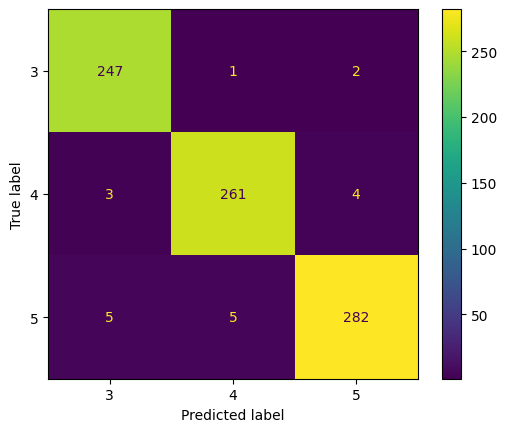

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_neural_net.classes_)
disp.plot()
plt.show()


La matriz de confusión muestra el número de predicciones correctas e incorrectas para cada clase (ODS 3, 4 y 5). Todos los valores diagonales son altos, lo que indica una alta tasa de aciertos para cada categoría. Además, los valores fuera de la diagonal son muy bajos, lo que sugiere pocas confusiones entre las diferentes categorías

De acuerdo a la matriz de confusión, se sabe que de acuerdo a cada ODS se obtienen los siguientes resultados:

ODS 3 (Etiqueta 3):
- Predicciones Correctas: 245
- Falsos Positivos: 5 (2 predicciones incorrectas como ODS 4 y 3 como ODS 5)
- Interpretación: El modelo clasifica la gran mayoría de las opiniones relacionadas con el ODS 3 correctamente. Solo un pequeño número de opiniones se confunden con los ODS 4 y 5.

ODS 4 (Etiqueta 4):
- Predicciones Correctas: 262
- Falsos Positivos: 6 (3 predicciones incorrectas como ODS 3, 3 como ODS 5)
- Interpretación: El modelo muestra un rendimiento excelente en la clasificación del ODS 4, con un número muy bajo de clasificaciones incorrectas, indicando que la clase está bien diferenciada.

ODS 5 (Etiqueta 5):
- Predicciones Correctas: 282
- Falsos Positivos: 10 (5 predicciones incorrectas como ODS 3, 5 como ODS 4)
- Interpretación: Aunque el ODS 5 también se clasifica correctamente en la mayoría de los casos, hay un ligero aumento en las confusiones con las otras dos clases, en comparación con las clases ODS 3 y 4.

### Métricas de rendimiento:

In [ ]:
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred_RN))
print("Recall: {}".format(recall_score(y_test,y_pred_RN, average='weighted')))
print("Precisión: {}".format(precision_score(y_test,y_pred_RN, average='weighted')))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred_RN, average='weighted')))

Exactitud: 0.98
Recall: 0.9753086419753086
Precisión: 0.9753716759279658
Puntuación F1: 0.9752927574062237


In [ ]:
print(classification_report(y_test, y_pred_RN))

              precision    recall  f1-score   support

           3       0.97      0.99      0.98       250
           4       0.98      0.97      0.98       268
           5       0.98      0.97      0.97       292

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810



Teniendo en cuenta las métricas de rendimiento, se concluye lo siguiente:

- La exactitud indica que el modelo clasificó correctamente el 97% de las opiniones en las categorías de los ODS 3, 4 y 5. Este es un buen indicador de que el modelo está funcionando de manera efectiva en general.
- El recall de 0.974 indica que el modelo tiene una alta tasa de detección de las opiniones correctas dentro de cada ODS, lo que es crucial para no perder información relevante.
- Una precisión de 0.974 sugiere que el modelo tiene una baja tasa de falsos positivos, lo que significa que es eficiente para evitar clasificaciones incorrectas.
- Una puntuación f1 de 0.974 indica que el modelo tiene un rendimiento equilibrado y robusto, lo cual es especialmente importante cuando las clases no están perfectamente balanceadas.

## Regresión Logística

### Matriz de confusión:

La matriz de confusión provee una visualización detallada del rendimiento del modelo de red neuronal en términos de la clasificación de las opiniones relacionadas con los ODS 3, 4 y 5.

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_RL = pipeline_logistic_reg.predict(X_test)

# Assuming y_test and y_pred are already defined
cm = confusion_matrix(y_test, y_pred_RL)

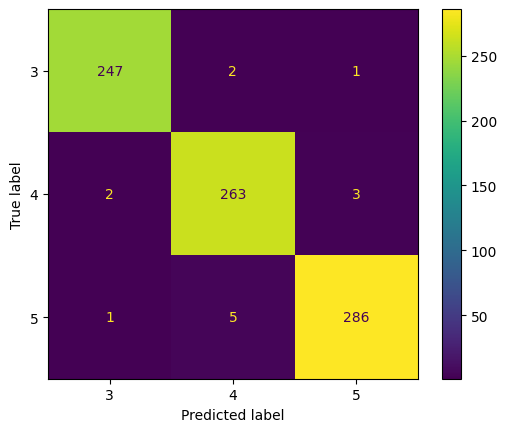

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_logistic_reg.classes_)
disp.plot()
plt.show()


La matriz de confusión muestra el número de predicciones correctas e incorrectas para cada clase (ODS 3, 4 y 5). Todos los valores diagonales son altos, lo que indica una alta tasa de aciertos para cada categoría. Además, los valores fuera de la diagonal son muy bajos, lo que sugiere pocas confusiones entre las diferentes categorías

De acuerdo a la matriz de confusión, se sabe que de acuerdo a cada ODS se obtienen los siguientes resultados:

ODS 3 (Etiqueta 3):
- Predicciones Correctas: 247
- Falsos Positivos: 3 (2 predicciones incorrectas como ODS 4, 1 como ODS 5)
- Interpretación: El modelo de regresión logística tiene un excelente rendimiento en la clasificación del ODS 3, con solo 3 instancias clasificadas incorrectamente, lo que indica una alta precisión en esta clase.

ODS 4 (Etiqueta 4):
- Predicciones Correctas: 263
- Falsos Positivos: 5 (2 predicciones incorrectas como ODS 3, 3 como ODS 5)
- Interpretación: La clasificación para el ODS 4 también es bastante precisa, con solo 5 errores, lo que sugiere que la clase está bien diferenciada en el modelo de regresión logística.

ODS 5 (Etiqueta 5):
- Predicciones Correctas: 286
- Falsos Positivos: 6 (1 predicción incorrecta como ODS 3, 5 como ODS 4)
- Interpretación: Aunque la clase ODS 5 muestra una ligera mejora en comparación con el modelo de red neuronal anterior, aún presenta algunos errores de clasificación, pero en general, la precisión sigue siendo alta.

### Métricas de rendimiento

In [ ]:
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred_RL))
print("Recall: {}".format(recall_score(y_test,y_pred_RL, average='weighted')))
print("Precisión: {}".format(precision_score(y_test,y_pred_RL, average='weighted')))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred_RL, average='weighted')))

Exactitud: 0.98
Recall: 0.9827160493827161
Precisión: 0.9827460069690805
Puntuación F1: 0.9827223737063326


In [ ]:
print(classification_report(y_test, y_pred_RL))

              precision    recall  f1-score   support

           3       0.99      0.99      0.99       250
           4       0.97      0.98      0.98       268
           5       0.99      0.98      0.98       292

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810



Teniendo en cuenta las métricas de rendimiento, se concluye lo siguiente:

- La exactitud del modelo es del 98%, es una indicación clara de que el modelo tiene un desempeño excelente y es confiable para realizar predicciones en la mayoría de los casos.
- Un recall de 0.9827 indica que el modelo logra detectar casi todas las opiniones correspondientes a cada ODS, minimizando el riesgo de omitir instancias relevantes.
- La precisión de 0.9827 refleja que el modelo tiene una baja tasa de falsos positivos.
- Un valor de puntuación f1 de 0.9827 indica que el modelo mantiene un equilibrio robusto entre la precisión y el recall, lo cual es crucial para un buen desempeño.

## Naive Bayes

### Matriz de confusión:

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred_NB = pipeline_naive_bayes.predict(X_test)

# Assuming y_test and y_pred are already defined
cm = confusion_matrix(y_test, y_pred_NB)

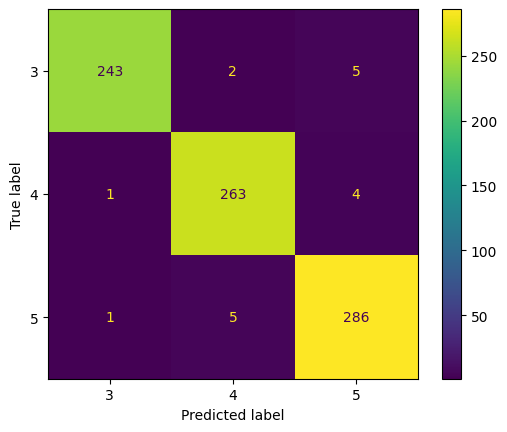

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline_naive_bayes.classes_)
disp.plot()
plt.show()


La matriz de confusión muestra el número de predicciones correctas e incorrectas para cada clase (ODS 3, 4 y 5). Todos los valores diagonales son altos, lo que indica una alta tasa de aciertos para cada categoría. Además, los valores fuera de la diagonal son muy bajos, lo que sugiere pocas confusiones entre las diferentes categorías

De acuerdo a la matriz de confusión, se sabe que de acuerdo a cada ODS se obtienen los siguientes resultados:

ODS 3 (Etiqueta 3):
- Predicciones Correctas: 243
- Falsos Positivos: 3 (2 predicciones incorrectas como ODS 4, 5 como ODS 5)
- Interpretación: El modelo de regresión logística tiene un excelente rendimiento en la clasificación del ODS 3, con solo 7 instancias clasificadas incorrectamente, lo que indica una alta precisión en esta clase, aunque es menor a la de los otros 2 modelos.

ODS 4 (Etiqueta 4):
- Predicciones Correctas: 263
- Falsos Positivos: 5 (1 prediccion incorrectas como ODS 3, 4 como ODS 5)
- Interpretación: La clasificación para el ODS 4 también es bastante precisa, con solo 5 errores, lo que sugiere que la clase está bien diferenciada en el modelo de regresión logística.

ODS 5 (Etiqueta 5):
- Predicciones Correctas: 286
- Falsos Positivos: 6 (1 predicción incorrecta como ODS 3, 5 como ODS 4)
- Interpretación: Aunque la clase ODS 5 muestra una ligera mejora en comparación con el modelo de red neuronal anterior, aún presenta algunos errores de clasificación, pero en general, la precisión sigue siendo alta e igual de buena a la regresion logica.

### Métricas de rendimiento

In [ ]:
print('Exactitud: %.2f' % accuracy_score(y_test, y_pred_NB))
print("Recall: {}".format(recall_score(y_test,y_pred_NB, average='weighted')))
print("Precisión: {}".format(precision_score(y_test,y_pred_NB, average='weighted')))
print("Puntuación F1: {}".format(f1_score(y_test,y_pred_NB, average='weighted')))

Exactitud: 0.98
Recall: 0.9777777777777777
Precisión: 0.9779043962333951
Puntuación F1: 0.9777965194830824


In [ ]:
print(classification_report(y_test, y_pred_NB))

              precision    recall  f1-score   support

           3       0.99      0.97      0.98       250
           4       0.97      0.98      0.98       268
           5       0.97      0.98      0.97       292

    accuracy                           0.98       810
   macro avg       0.98      0.98      0.98       810
weighted avg       0.98      0.98      0.98       810



Teniendo en cuenta las métricas de rendimiento, se concluye lo siguiente:

- Teniendo en cuelta la exactitud del 0.98 el modelo clasifica correctamente el 98% de las opiniones en las categorías de los ODS.
- Gracias a su alto recall 0.978, el modelo logra identificar la gran mayoría de las opiniones relevantes en cada uno de los ODS. Esto minimiza el riesgo de omitir instancias relevantes.
- La precisión de 0.9779 refleja que el modelo tiene una baja tasa de falsos positivos, lo que significa que la mayoría de las instancias clasificadas como pertenecientes a un ODS en particular son efectivamente de ese ODS.
- Un valor de f1 de 0.9778 indica que el modelo mantiene un buen equilibrio entre presición y recall.

# 6. Presentación de resultados

##Palabras más relevantes que relacionan las opiniones con los ODS


### Regresión Logística

In [ ]:
logistic_regression_words_class1=set()
logistic_regression_words_class2=set()
logistic_regression_words_class3=set()

tfidf = pipeline_logistic_reg.named_steps['tfidf']  # El vectorizador TF-IDF
log_reg = pipeline_logistic_reg.named_steps['classifier']  # El clasificador de regresión logística

# Obtenemos las palabras del vocabulario del vectorizador
feature_names = tfidf.get_feature_names_out()

# Los coeficientes del modelo de regresión logística
coef = log_reg.coef_

# Obtenemos las palabras más importantes por cada clase (ODS)
top_n = 10  # Número de palabras más importantes a mostrar por clase
for i, class_label in enumerate(log_reg.classes_):
    top_features = sorted(zip(coef[i], feature_names), reverse=True)[:top_n]
    print(f"Palabras clave para la clase {class_label}:")
    for coef_val, feature in top_features:
      if(class_label==3):
        logistic_regression_words_class1.add(feature)
      elif(class_label==4):
        logistic_regression_words_class2.add(feature)
      elif(class_label==5):
        logistic_regression_words_class3.add(feature)
      coef_val=round(coef_val,2)
      print(f"{feature}: {coef_val}")

    print("\n")


Palabras clave para la clase 3:
salud: 5.19
atención: 3.21
sanitario: 3.03
enfermedad: 2.75
médico: 2.71
paciente: 2.7
mortalidad: 1.85
hospital: 1.83
tratamiento: 1.77
mental: 1.69


Palabras clave para la clase 4:
educación: 4.57
escuela: 3.77
estudiante: 3.2
aprendizaje: 2.98
docente: 2.85
escolar: 2.79
educativo: 2.65
profesor: 2.31
alumno: 2.26
estudiant: 1.86


Palabras clave para la clase 5:
mujer: 8.43
género: 6.17
niña: 2.26
igualdad: 2.16
femenino: 1.89
violencia: 1.76
hombre: 1.72
sexual: 1.48
derechos: 1.48
matrimonio: 1.35


{'mortalidad', 'hospital', 'enfermedad', 'salud', 'sanitario', 'paciente', 'tratamiento', 'mental', 'médico', 'atención'}
{'docente', 'educación', 'alumno', 'profesor', 'aprendizaje', 'escuela', 'estudiant', 'educativo', 'escolar', 'estudiante'}
{'derechos', 'hombre', 'niña', 'mujer', 'violencia', 'género', 'igualdad', 'matrimonio', 'sexual', 'femenino'}


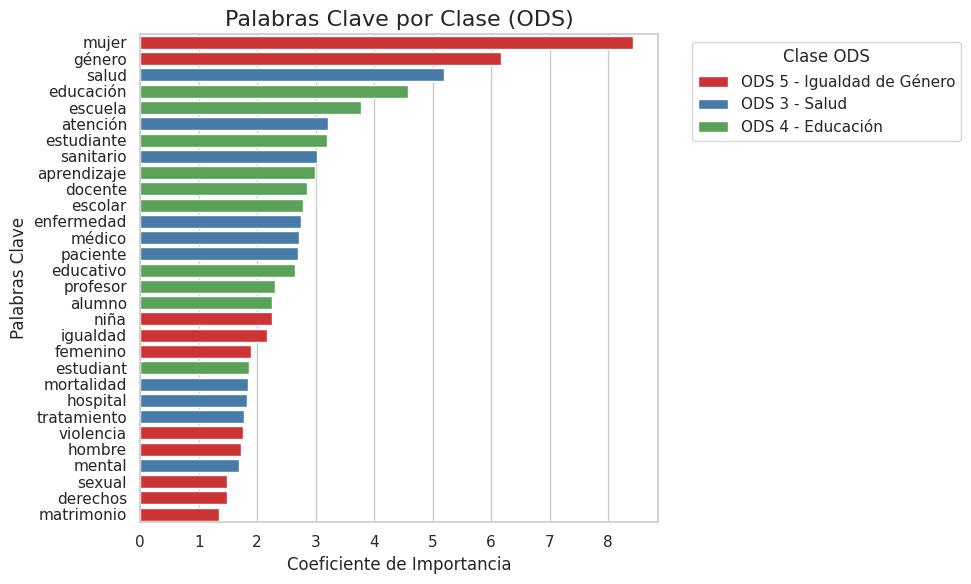

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configuración de estilo para que el gráfico sea más atractivo
sns.set(style="whitegrid")

# Datos de palabras clave y coeficientes por clase
ods3_words = {
    "salud": 5.19, "atención": 3.21, "sanitario": 3.03, "enfermedad": 2.75,
    "médico": 2.71, "paciente": 2.7, "mortalidad": 1.85, "hospital": 1.83,
    "tratamiento": 1.77, "mental": 1.69
}
ods4_words = {
    "educación": 4.57, "escuela": 3.77, "estudiante": 3.2, "aprendizaje": 2.98,
    "docente": 2.85, "escolar": 2.79, "educativo": 2.65, "profesor": 2.31,
    "alumno": 2.26, "estudiant": 1.86
}
ods5_words = {
    "mujer": 8.43, "género": 6.17, "niña": 2.26, "igualdad": 2.16, "femenino": 1.89,
    "violencia": 1.76, "hombre": 1.72, "sexual": 1.48, "derechos": 1.48, "matrimonio": 1.35
}

# Convertimos los datos en un DataFrame para una manipulación más fácil
df_ods3 = pd.DataFrame(list(ods3_words.items()), columns=["Palabra", "Coeficiente"])
df_ods3["Clase"] = "ODS 3 - Salud"

df_ods4 = pd.DataFrame(list(ods4_words.items()), columns=["Palabra", "Coeficiente"])
df_ods4["Clase"] = "ODS 4 - Educación"

df_ods5 = pd.DataFrame(list(ods5_words.items()), columns=["Palabra", "Coeficiente"])
df_ods5["Clase"] = "ODS 5 - Igualdad de Género"

# Concatenamos los DataFrames
df = pd.concat([df_ods3, df_ods4, df_ods5])

# Ordenamos por coeficiente para mejor visualización
df = df.sort_values(by="Coeficiente", ascending=False)

# Crear un gráfico de barras apiladas
plt.figure(figsize=(10, 6))
sns.barplot(x="Coeficiente", y="Palabra", hue="Clase", data=df, palette="Set1")

# Personalizar el gráfico
plt.title("Palabras Clave por Clase (ODS)", fontsize=16)
plt.xlabel("Coeficiente de Importancia", fontsize=12)
plt.ylabel("Palabras Clave", fontsize=12)
plt.legend(title="Clase ODS", bbox_to_anchor=(1.05, 1), loc='upper left')

# Mostramos el gráfico
plt.tight_layout()
plt.show()


###Red neuronal


In [ ]:
from collections import defaultdict

neural_network_words_class1=set()
neural_network_words_class2=set()
neural_network_words_class3=set()
tfidf_nn = pipeline_neural_net.named_steps['tfidf']

# Obtenemos las palabras del vocabulario del vectorizador
feature_names_nn = tfidf_nn.get_feature_names_out()

# Transformamos los datos de entrenamiento a una matriz TF-IDF
tfidf_matrix = tfidf_nn.transform(X_train)

# Inicializamos un diccionario para almacenar los promedios de TF-IDF por clase
class_word_importance = defaultdict(list)

# Agrupamos las opiniones según su clase (ODS) en el conjunto de entrenamiento
for class_label in pipeline_neural_net.named_steps['classifier'].classes_:
    class_indices = (y_train == class_label)
    tfidf_mean_values = tfidf_matrix[class_indices].mean(axis=0).A1

    # Guardamos las palabras más importantes por cada clase
    top_n = 10
    top_words = sorted(zip(tfidf_mean_values, feature_names_nn), reverse=True)[:top_n]

    # Almacenamos las palabras clave para la clase
    class_word_importance[class_label] = top_words

# Imprimimos las palabras clave por clase
for class_label, top_words in class_word_importance.items():
    print(f"Palabras clave para la clase {class_label}:")
    for score, word in top_words:
      if(class_label==3):
        neural_network_words_class1.add(word)
      elif(class_label==4):
        neural_network_words_class2.add(word)
      elif(class_label==5):
        neural_network_words_class3.add(word)
      score=round(score,2)
      print(f"{word}: {score}")

    print("\n")


Palabras clave para la clase 3:
servicios: 0.09
salud: 0.08
atención: 0.06
enfermedades: 0.05
países: 0.05
médicos: 0.04
años: 0.04
primaria: 0.04
resultados: 0.03
datos: 0.03


Palabras clave para la clase 4:
escuelas: 0.08
estudiantes: 0.07
educación: 0.06
resultados: 0.05
profesores: 0.04
este: 0.04
países: 0.04
aprendizaje: 0.04
años: 0.03
niños: 0.03


Palabras clave para la clase 5:
mujeres: 0.23
género: 0.07
países: 0.05
igualdad: 0.03
este: 0.03
derechos: 0.03
datos: 0.03
trabajo: 0.03
ingresos: 0.02
violencia: 0.02


{'servicios', 'resultados', 'años', 'datos', 'salud', 'primaria', 'países', 'médicos', 'enfermedades', 'atención'}
{'profesores', 'escuelas', 'estudiantes', 'educación', 'resultados', 'años', 'aprendizaje', 'niños', 'este', 'países'}
{'derechos', 'trabajo', 'violencia', 'género', 'igualdad', 'datos', 'este', 'países', 'ingresos', 'mujeres'}


###Naive Bayes

In [ ]:
naive_bayes_words_class1=set()
naive_bayes_words_class2=set()
naive_bayes_words_class3=set()
tfidf_nb = pipeline_naive_bayes.named_steps['tfidf']  # El vectorizador TF-IDF
naive_bayes = pipeline_naive_bayes.named_steps['classifier']  # El clasificador Naive Bayes

# Obtenemos las palabras del vocabulario del vectorizador
feature_names_nb = tfidf_nb.get_feature_names_out()

# Obtenemos las probabilidades logarítmicas del modelo Naive Bayes para cada clase
log_prob = naive_bayes.feature_log_prob_

# Para cada clase (ODS), mostramos las palabras más importantes
top_n = 10  # Número de palabras más importantes a mostrar por clase
for i, class_label in enumerate(naive_bayes.classes_):

    top_features = sorted(zip(log_prob[i], feature_names_nb), reverse=True)[:top_n]
    print(f"Palabras clave para la clase {class_label}:")
    for log_prob_val, feature in top_features:
      if(class_label==3):
        naive_bayes_words_class1.add(feature)
      elif(class_label==4):
          naive_bayes_words_class2.add(feature)
      elif(class_label==5):
          naive_bayes_words_class3.add(feature)
      log_prob_val=round(log_prob_val,2)
      print(f"{feature}: {log_prob_val}")


    print("\n")

print(naive_bayes_words_class1)
print(naive_bayes_words_class2)
print(naive_bayes_words_class3)


Palabras clave para la clase 3:
salud: -4.63
atención: -4.82
servicio: -5.34
médico: -5.35
sanitario: -5.43
paciente: -5.44
mental: -5.47
enfermedad: -5.57
país: -5.75
sistema: -5.78


Palabras clave para la clase 4:
educación: -4.85
escuela: -4.93
docente: -5.22
escolar: -5.34
estudiante: -5.35
aprendizaje: -5.38
evaluación: -5.49
educativo: -5.53
alumno: -5.53
poder: -5.67


Palabras clave para la clase 5:
mujer: -4.25
género: -4.67
igualdad: -5.51
poder: -5.54
hombre: -5.55
trabajo: -5.69
país: -5.8
violencia: -5.92
laboral: -5.96
social: -5.96


{'servicio', 'enfermedad', 'salud', 'sanitario', 'paciente', 'país', 'mental', 'sistema', 'médico', 'atención'}
{'docente', 'estudiante', 'educación', 'alumno', 'poder', 'aprendizaje', 'escuela', 'educativo', 'evaluación', 'escolar'}
{'hombre', 'mujer', 'violencia', 'género', 'poder', 'igualdad', 'país', 'laboral', 'social', 'trabajo'}


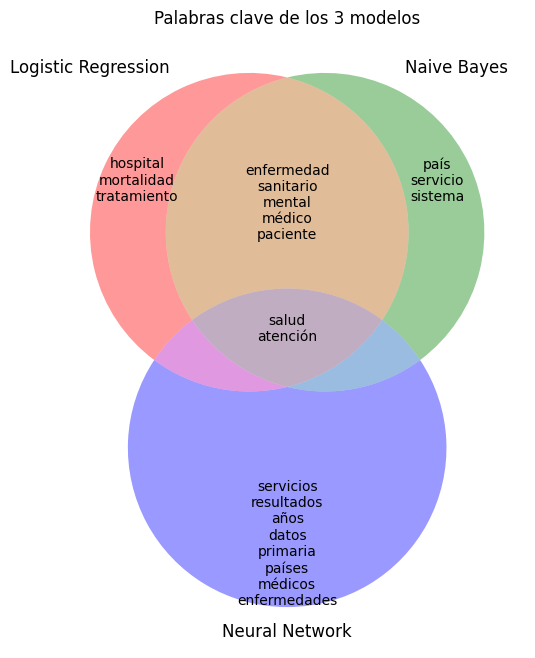

In [ ]:

plt.figure(figsize=(8, 8))

# Crear el diagrama con las palabras clave
venn = venn3([logistic_regression_words_class1, naive_bayes_words_class1, neural_network_words_class1],
             set_labels=('Logistic Regression', 'Naive Bayes', 'Neural Network'))

venn.get_label_by_id('100').set_text('\n'.join(logistic_regression_words_class1 - naive_bayes_words_class1 - neural_network_words_class1))
venn.get_label_by_id('010').set_text('\n'.join(naive_bayes_words_class1 - logistic_regression_words_class1 - neural_network_words_class1))
venn.get_label_by_id('001').set_text('\n'.join(neural_network_words_class1 - logistic_regression_words_class1 - naive_bayes_words_class1))
venn.get_label_by_id('110').set_text('\n'.join(logistic_regression_words_class1 & naive_bayes_words_class1 - neural_network_words_class1))
venn.get_label_by_id('101').set_text('\n'.join(logistic_regression_words_class1 & neural_network_words_class1 - naive_bayes_words_class1))
venn.get_label_by_id('011').set_text('\n'.join(naive_bayes_words_class1 & neural_network_words_class1 - logistic_regression_words_class1))
venn.get_label_by_id('111').set_text('\n'.join(logistic_regression_words_class1 & naive_bayes_words_class1 & neural_network_words_class1))

# Mostrar el diagrama con las palabras
plt.title("Palabras clave de los 3 modelos")
plt.savefig('diagrama_clase_1.png')
plt.show()




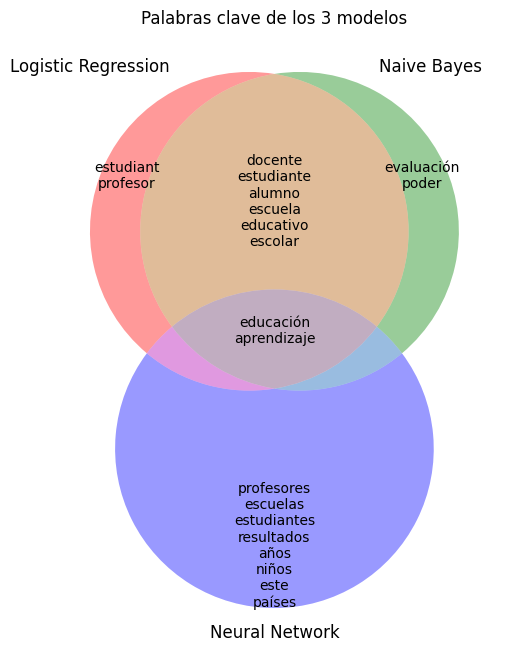

In [ ]:

plt.figure(figsize=(8, 8))

# Crear el diagrama con las palabras clave
venn = venn3([logistic_regression_words_class2, naive_bayes_words_class2, neural_network_words_class2],
             set_labels=('Logistic Regression', 'Naive Bayes', 'Neural Network'))

venn.get_label_by_id('100').set_text('\n'.join(logistic_regression_words_class2 - naive_bayes_words_class2 - neural_network_words_class2))
venn.get_label_by_id('010').set_text('\n'.join(naive_bayes_words_class2 - logistic_regression_words_class2 - neural_network_words_class2))
venn.get_label_by_id('001').set_text('\n'.join(neural_network_words_class2 - logistic_regression_words_class2 - naive_bayes_words_class2))
venn.get_label_by_id('110').set_text('\n'.join(logistic_regression_words_class2 & naive_bayes_words_class2 - neural_network_words_class2))
venn.get_label_by_id('101').set_text('\n'.join(logistic_regression_words_class2 & neural_network_words_class2 - naive_bayes_words_class2))
venn.get_label_by_id('011').set_text('\n'.join(naive_bayes_words_class2 & neural_network_words_class2 - logistic_regression_words_class2))
venn.get_label_by_id('111').set_text('\n'.join(logistic_regression_words_class2 & naive_bayes_words_class2 & neural_network_words_class2))

# Mostrar el diagrama con las palabras
plt.title("Palabras clave de los 3 modelos")
plt.savefig('diagrama_clase_2.png')
plt.show()




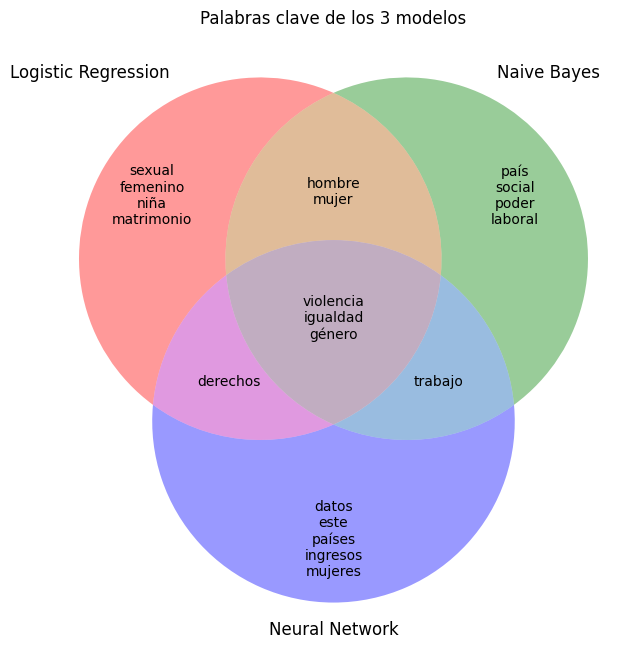

In [ ]:

plt.figure(figsize=(8, 8))

# Crear el diagrama con las palabras clave
venn = venn3([logistic_regression_words_class3, naive_bayes_words_class3, neural_network_words_class3],
             set_labels=('Logistic Regression', 'Naive Bayes', 'Neural Network'))

venn.get_label_by_id('100').set_text('\n'.join(logistic_regression_words_class3 - naive_bayes_words_class3 - neural_network_words_class3))
venn.get_label_by_id('010').set_text('\n'.join(naive_bayes_words_class3 - logistic_regression_words_class3 - neural_network_words_class3))
venn.get_label_by_id('001').set_text('\n'.join(neural_network_words_class3 - logistic_regression_words_class3 - naive_bayes_words_class3))
venn.get_label_by_id('110').set_text('\n'.join(logistic_regression_words_class3 & naive_bayes_words_class3 - neural_network_words_class3))
venn.get_label_by_id('101').set_text('\n'.join(logistic_regression_words_class3 & neural_network_words_class3 - naive_bayes_words_class3))
venn.get_label_by_id('011').set_text('\n'.join(naive_bayes_words_class3 & neural_network_words_class3 - logistic_regression_words_class3))
venn.get_label_by_id('111').set_text('\n'.join(logistic_regression_words_class3 & naive_bayes_words_class3 & neural_network_words_class3))

# Mostrar el diagrama con las palabras
plt.title("Palabras clave de los 3 modelos")
plt.savefig('diagrama_clase_3.png')
plt.show()




Video:

# 7. Exportación del modelo óptimo

Exportación y serialización del mejor modelo utilizando pipelines y serialización.

In [20]:
import joblib

In [22]:
joblib.dump(pipeline_logistic_reg, 'pipeline_logistic_reg.pkl')

['pipeline_logistic_reg.pkl']

# 8. Predicciones sobre los datos de prueba

 Exportación de las predicciones en formato CSV utlizando como base el mismo archivo de datos de prueba.

In [25]:
model = joblib.load('pipeline_logistic_reg.pkl')

data = pd.read_excel('/content/TestODScat_345.xlsx')

input = data.copy()

y_pred = model.predict(input['Textos_espanol'])

data['sdg'] = y_pred

data.to_excel('predictions.xlsx')


